# Getting Started

Follow the general instructions from hw1_Q1

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('/teamspace/studios/this_studio/MAI_DUL_WS24')
# os.chdir('../../')
os.getcwd()

'/teamspace/studios/this_studio/MAI_DUL_WS24'

In [2]:
# run only once at the beginning of working on hw1
# !unzip -qq homeworks/hw1/data/hw1_data.zip -d homeworks/hw1/data/

# install latest version deepul package
!pip install -e .

Obtaining file:///teamspace/studios/this_studio/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///teamspace/studios/this_studio/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


In [3]:
import numpy as np
from deepul.hw1_helper import (
    # Q5
    visualize_q5_data,
    q5a_save_results,
)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [4]:
data = visualize_q5_data()

Sample 1
Strephon kissed me in the spring,
Robin in the fall,
But Colin only looked at me
And never kissed at all.

Strephon's kiss was lost in jest,
Robin's lost in play,
But the kiss in Colin's eyes
Haunts me night and day.
--------------------------------------------------------------------------------

Sample 2
Ezra Pound, "Canto IV" from The Cantos of Ezra Pound. Copyright  1993 by Ezra Pound. Reprinted by permission of New Directions Publishing Corporation.
--------------------------------------------------------------------------------

Sample 3
Green groweth the holly,
So doth the ivy.
Though winter blasts blow never so high,
Green groweth the holly.

As the holly groweth green
And never changeth hue,
So I am, ever hath been,
Unto my lady true.

As the holly groweth green
With ivy all alone
When flowers cannot be seen
And greenwood leaves be gone,

Now unto my lady
Promise to her I make,
From all other only
To her I me betake.

Adieu, mine own lady,
Adieu, my special
Who hath m

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

from torch.utils.data import Dataset, DataLoader
from typing import List
from tqdm.notebook import tqdm
from transformer import TextGPT

In [6]:
class TextDataset(Dataset):
    def __init__(self, text_sequences: List[str], context_length: int):
        self.context_length = context_length
        
        # Create vocabulary (char to index mapping)
        unique_chars = set(''.join(text_sequences))
        self.char_to_idx = {char: idx for idx, char in enumerate(sorted(unique_chars), start=2)}  # Start from 2 for special tokens
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx) + 2  # Add <bos> and <eos> tokens
        
        # Special tokens
        self.BOS_TOKEN = 0
        self.EOS_TOKEN = 1
        
        # Process sequences
        self.sequences = []
        for text in text_sequences:
            # Convert text to indices and add special tokens
            indices = [self.BOS_TOKEN] + [self.char_to_idx[c] for c in text] + [self.EOS_TOKEN]
            
            # Create subsequences of context_length
            for i in range(0, len(indices) - context_length + 1):
                self.sequences.append(indices[i:i + context_length])
        
        self.sequences = torch.tensor(self.sequences)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        # Input is all tokens except last, target is all tokens except first
        return sequence[:-1], sequence[1:]

In [7]:
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [8]:
def train_one_epoch(model, train_loader, optimizer, scheduler, causal_mask, device):
    model.train()
    batch_losses = []
    pbar = tqdm(train_loader, unit='batch')
    for batch_idx, (data, target) in enumerate(pbar):
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
        data, target = data.to(device), target.to(device)
        seq_len = data.size(1)
        current_mask = causal_mask[:seq_len, :seq_len]

        optimizer.zero_grad()
        output = model(data, current_mask)
        loss = F.cross_entropy(output.view(-1, output.size(-1)), target.view(-1))
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        # Record losses
        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        pbar.set_description(desc=f"batch_loss={batch_loss:.4f}")

    return batch_losses

In [9]:
def evaluate_model(model, test_loader, device, causal_mask):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Create causal mask
            seq_len = data.size(1)
            current_mask = causal_mask[:seq_len, :seq_len]
            
            output = model(data, current_mask)
            loss = F.cross_entropy(output.view(-1, output.size(-1)), target.view(-1))
            total_loss += loss.item()
            
    return total_loss / len(test_loader)

In [10]:
def train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs, context_length, device):
    # Create causal mask once
    causal_mask = torch.tril(torch.ones(context_length, context_length, device=device))

    train_losses = []
    test_losses = [evaluate_model(model, test_loader, device, causal_mask)]
    
    for epoch in range(num_epochs):
        # Train one epoch
        batch_losses = train_one_epoch(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            causal_mask=causal_mask,
            device=device
        )
        
        # Record losses
        train_losses.extend(batch_losses)
        
        # Evaluate on test set
        test_loss = evaluate_model(model, test_loader, device, causal_mask)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}')
    
    torch.cuda.empty_cache()
    return train_losses, test_losses

In [11]:
def generate_samples(model, context_length, dataset, device, num_samples=5, temperature=0.7):
    model.eval()
    samples = []
    
    with torch.no_grad():
        for _ in range(num_samples):
            # Start with BOS token
            x = torch.tensor([dataset.BOS_TOKEN], dtype=torch.long, device=device).unsqueeze(0)
            
            for _ in range(context_length):
                # Get predictions
                logits = model(x)
                next_token_logits = logits[0, -1, :] / temperature
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
                # Stop if EOS token is generated
                if next_token.item() == dataset.EOS_TOKEN:
                    break
                    
                x = torch.cat([x, next_token.unsqueeze(0)], dim=1)
            
            # Convert tokens to text
            generated_text = ''
            for idx in x[0, 1:]:  # Skip BOS token
                if idx.item() == dataset.EOS_TOKEN:
                    break
                generated_text += dataset.idx_to_char[idx.item()]
            samples.append(generated_text)
            
    return samples

In [12]:
def q5_a(train_text: List[str], test_text: List[str]):
    """
    train_text: list[str] Train text sequences.
    test_text: list[str] Test text sequences.

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 5 (str), 5 generated samples from the model.
    """

    torch.manual_seed(1)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() 
                         else "mps" if torch.backends.mps.is_available() 
                         else "cpu")
    print(f"Using device: {device}")
    
    # DataLoader settings based on device
    kwargs = {'num_workers': 8, 'pin_memory': True} if torch.cuda.is_available() else \
            {'num_workers': 0} if torch.backends.mps.is_available() else \
            {}

    # Hyperparameters
    D_MODEL = 128
    NUM_HEADS = 4
    NUM_LAYERS = 2
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-3
    NUM_EPOCHS = 5
    CONTEXT_LENGTH = 128

    # Create datasets
    train_dataset = TextDataset(train_text, CONTEXT_LENGTH)
    test_dataset = TextDataset(test_text, CONTEXT_LENGTH)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Initialize model
    model = TextGPT(
        vocab_size=train_dataset.vocab_size,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        context_length=CONTEXT_LENGTH-1  # -1 because input sequence is one shorter
    ).to(device)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Calculate number of training steps for scheduler
    num_training_steps = len(train_loader) * NUM_EPOCHS
    num_warmup_steps = 1000
    
    # Initialize scheduler
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )
    # train_losses = []
    # test_losses = []
    # samples = []

    # Train model
    train_losses, test_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=NUM_EPOCHS,
        context_length=CONTEXT_LENGTH-1,
        device=device
    )
    
    # Generate samples
    samples = generate_samples(
        model=model,
        context_length=CONTEXT_LENGTH-1,
        dataset=train_dataset,
        device=device,
        num_samples=5,
        temperature=0.7
    )
    
    return np.array(train_losses), np.array(test_losses), samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



Using device: cuda


  0%|          | 0/15249 [00:00<?, ?batch/s]

Epoch 1/5, Test Loss: 12.8967


  0%|          | 0/15249 [00:00<?, ?batch/s]

Epoch 2/5, Test Loss: 19.2491


  0%|          | 0/15249 [00:00<?, ?batch/s]

Epoch 3/5, Test Loss: 24.1339


  0%|          | 0/15249 [00:00<?, ?batch/s]

Epoch 4/5, Test Loss: 27.5637


  0%|          | 0/15249 [00:00<?, ?batch/s]

Epoch 5/5, Test Loss: 28.3270
Final Test Loss: 28.3270


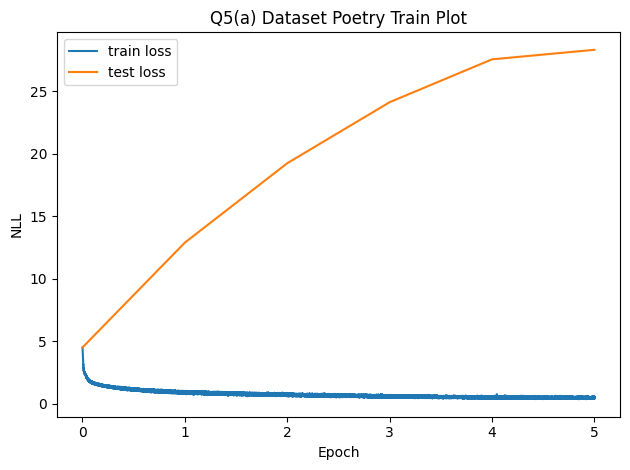

Sample 1
Before from a place commandes to beach:
it keensse re shall of love; for her not as he own amidst thought: sweeps to far! thou

Sample 2
strooke, the carter it towarve this more shape
Our two double black will ore, too falseeming to have,
Whileur their, sulse of

Sample 3
me where she was the boylefull I watch to ease.
Younge it impeth won? . even thee was in love theirs sort; we are hartest cont

Sample 4
Or of what the that and sight, all her, to fly!"
Dear not you see the passed affer
Of me, feature is ind millions and beauty 

Sample 5
With the heightender retcas,
Released softly ching nold destruce in who their of the morniteothly, my fed; like which thoughts



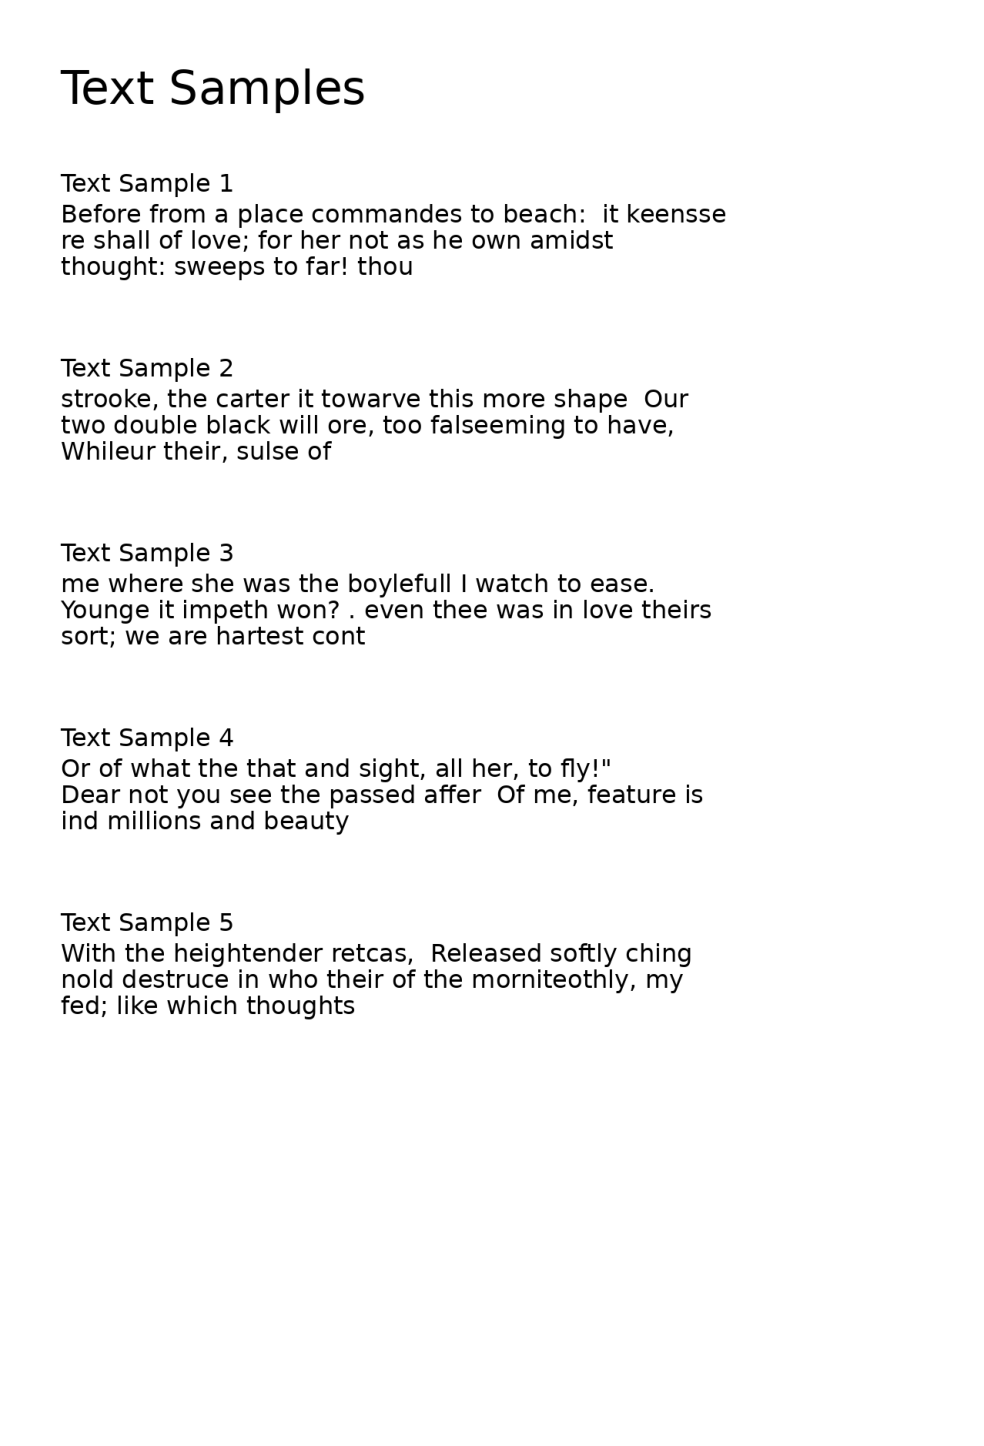

In [13]:
q5a_save_results(q5_a)